<a href="https://colab.research.google.com/github/Yoshibansal/ML-practical/blob/main/Horses%20vs%20Humans-Transfer%20learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###TRANSFER LEARNING
Inception V3

Horses vs humans dataset
http://www.laurencemoroney.com/horses-or-humans-dataset/

Binary class classification


In [1]:
#importing libraries
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable (freezing layers)
for layer in pre_trained_model.layers:
  layer.trainable = False
 
# Print the model summary
pre_trained_model.summary()

--2020-12-10 17:30:20--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.112, 172.217.164.144, 172.217.8.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   156MB/s    in 0.5s    

2020-12-10 17:30:20 (156 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                   

In [3]:
#this is a huge model, so rather then selecting the whole model we will consider only a small part
last_layer = pre_trained_model.get_layer('mixed7') #mixed7 is a layer name (find in summary)
print('last layer output shape: ', last_layer.output_shape) #this output shape will be the input of our model
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [4]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True 

In [5]:
from tensorflow.keras.optimizers import RMSprop

#-------------------------------------------
#ADDING SOME LAYERS (TRAINABLE) IN THE END 
#--------------------------------------------

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           


model = Model(pre_trained_model.input, x) 


model.compile(optimizer = RMSprop(lr=0.0001), #lr= learning rate 1e-4 
              loss = 'binary_crossentropy',  #2 class classification
              metrics = ['accuracy'])


model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [6]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [7]:
# Get the Horse or Human dataset

'''Dataset from:- http://www.laurencemoroney.com/horses-or-humans-dataset/'''

!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

--2020-12-10 17:38:21--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 172.217.15.80, 172.217.164.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  75.8MB/s    in 1.9s    

2020-12-10 17:38:23 (75.8 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-12-10 17:38:23--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 172.217.13.240, 172.217.164.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1

In [11]:
# Define our example directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir, 'horses') # Directory with our training horse pictures
train_humans_dir = os.path.join(train_dir, 'humans') # Directory with our training humans pictures
validation_horses_dir = os.path.join(validation_dir, 'horses') # Directory with our validation horse pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')# Directory with our validation humanas pictures

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print("Training (Horse)   : ", len(train_horses_fnames))
print("Training (Humans)  : ", len(train_humans_fnames))
print("Validation (Horse) : ", len(validation_horses_fnames))
print("Validation (Humans): ", len(validation_humans_fnames))

Training (Horse)   :  500
Training (Humans)  :  527
Validation (Horse) :  128
Validation (Humans):  128


In [12]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [15]:
# Run this and see how many epochs it should take before the callback fires, and stops training at 99.9% accuracy
callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 100, #you will soon get accuracy near to 100%
            verbose = 1,
            callbacks=[callbacks])


Epoch 1/100
52/52 [==============================] - 11s 213ms/step - loss: 0.0381 - accuracy: 0.9825 - val_loss: 0.1214 - val_accuracy: 0.9688
Epoch 2/100
52/52 [==============================] - 11s 212ms/step - loss: 0.0196 - accuracy: 0.9903 - val_loss: 0.0266 - val_accuracy: 0.9922
Epoch 3/100
52/52 [==============================] - 11s 210ms/step - loss: 0.0236 - accuracy: 0.9951 - val_loss: 0.0293 - val_accuracy: 0.9961
Epoch 4/100
52/52 [==============================] - 11s 212ms/step - loss: 0.0123 - accuracy: 0.9932 - val_loss: 0.0389 - val_accuracy: 0.9922
Epoch 5/100
52/52 [==============================] - 11s 217ms/step - loss: 0.0114 - accuracy: 0.9981 - val_loss: 8.5208e-04 - val_accuracy: 1.0000
Epoch 6/100
52/52 [==============================] - 11s 213ms/step - loss: 0.0084 - accuracy: 0.9971 - val_loss: 1.2149e-04 - val_accuracy: 1.0000
Epoch 7/100
52/52 [==============================] - 11s 210ms/step - loss: 0.0124 - accuracy: 0.9961 - val_loss: 4.2592e-04 - v

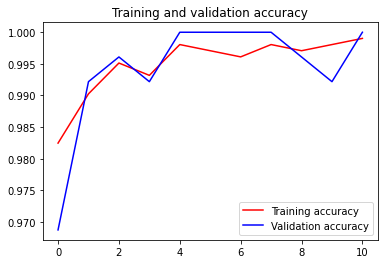

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

Since the dataset was to small you will soon get the accuracy near to 100%. But that doesn't mean that your model will surely have same accuracy in test and production.